# Movie remakes analysis

In [30]:
# import required libraries

import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import csv
import os
import re

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
import json
import ast

from ada_config.config import CONFIG

## Loading data

In [68]:
# load movie metadata

# Load movie metadata
df_movies = pd.read_csv(CONFIG["data_path"] / "enrich_movie_data.csv")

# Load charachter metadata
df_chars  = pd.read_csv(CONFIG["cmu_path"] / "character_metadata.csv")

# load movie remakes data

movie_remakes_df = pd.read_csv(CONFIG["data_path"] / 'remakes.csv')

C:\Users\Amirmahdi\AppData\Local\Temp\ipykernel_11492\2638662591.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv(CONFIG["data_path"] / "enrich_movie_data.csv")


In [71]:
# drop nan values from wiidata id
movie_remakes_df = movie_remakes_df.dropna(subset=["remake_wikidata_id", "original_wikidata_id"])

In [72]:
original_movies_wikidata = list(movie_remakes_df["original_wikidata_id"].unique())

remakes_movies_wikidata = list(movie_remakes_df["remake_wikidata_id"].unique())

In [73]:
original_df = df_movies[df_movies["wikidata_id"].isin(original_movies_wikidata)]

remakes_df = df_movies[df_movies["wikidata_id"].isin(remakes_movies_wikidata)]

## Revenue Analysis

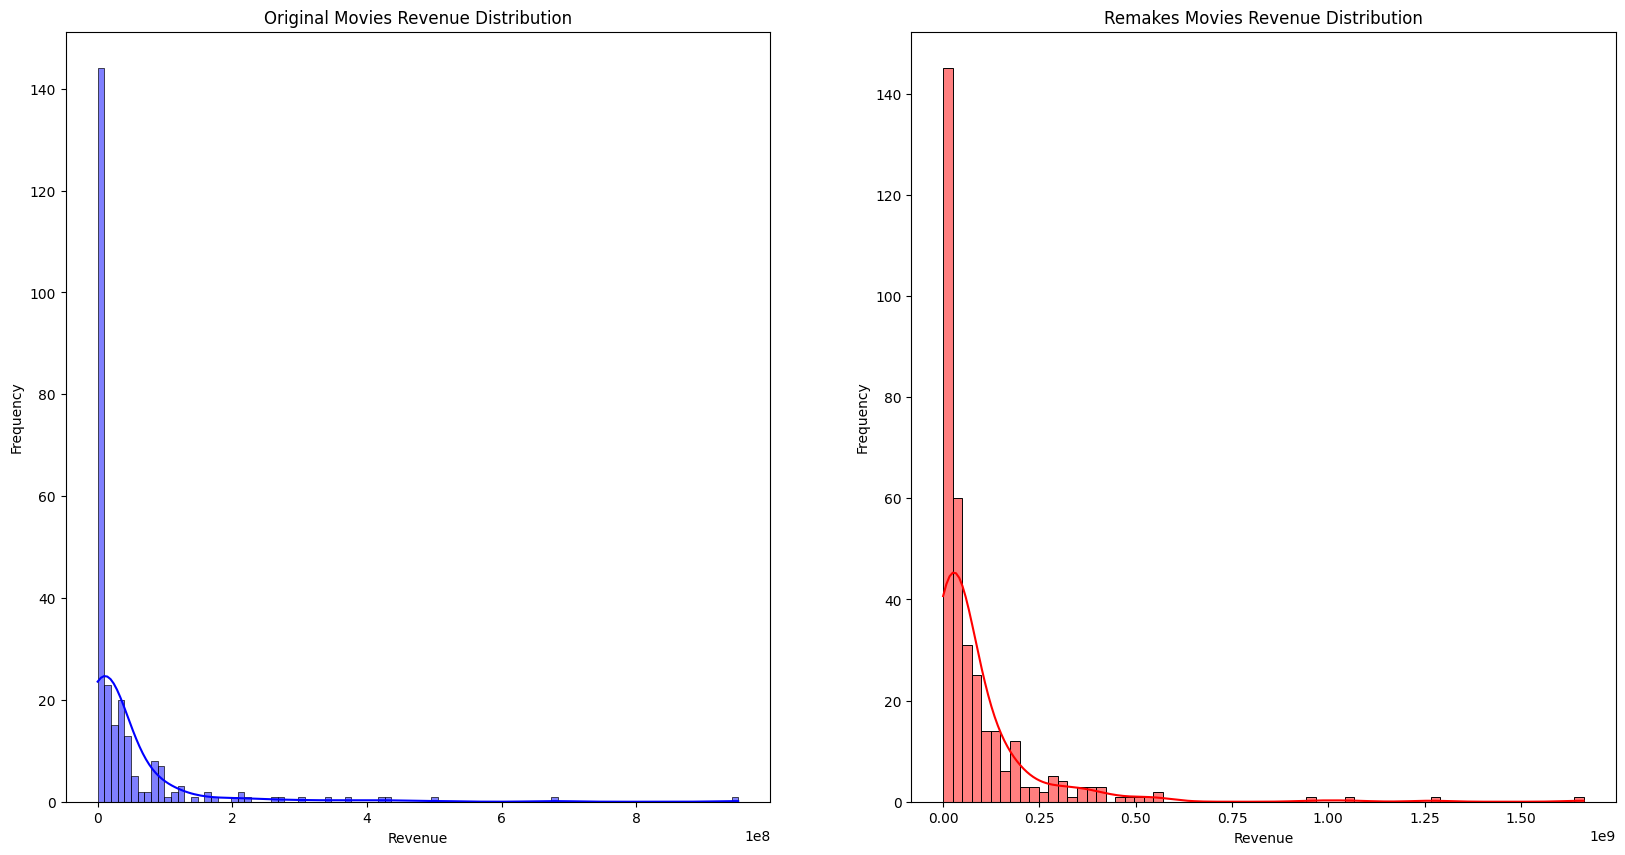

In [79]:
# plot distribition of remakes and original movies revenues

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

sns.histplot(original_df["movie_revenue"], ax=ax[0], color="blue", kde=True)
ax[0].set_title("Original Movies Revenue Distribution")
ax[0].set_xlabel("Revenue")
ax[0].set_ylabel("Frequency")

sns.histplot(remakes_df["movie_revenue"], ax=ax[1], color="red", kde=True)
ax[1].set_title("Remakes Movies Revenue Distribution")
ax[1].set_xlabel("Revenue")
ax[1].set_ylabel("Frequency")

plt.show()

In [ ]:
print("Mean revenue for original movies:", original_df["movie_revenue"].mean())

print("Mean revenue for whole dataset:", remakes_df["movie_revenue"].mean())

print("Mean revenue for remakes:", df_movies["movie_revenue"].mean())

Mean revenue for original movies: 41623667.003802285


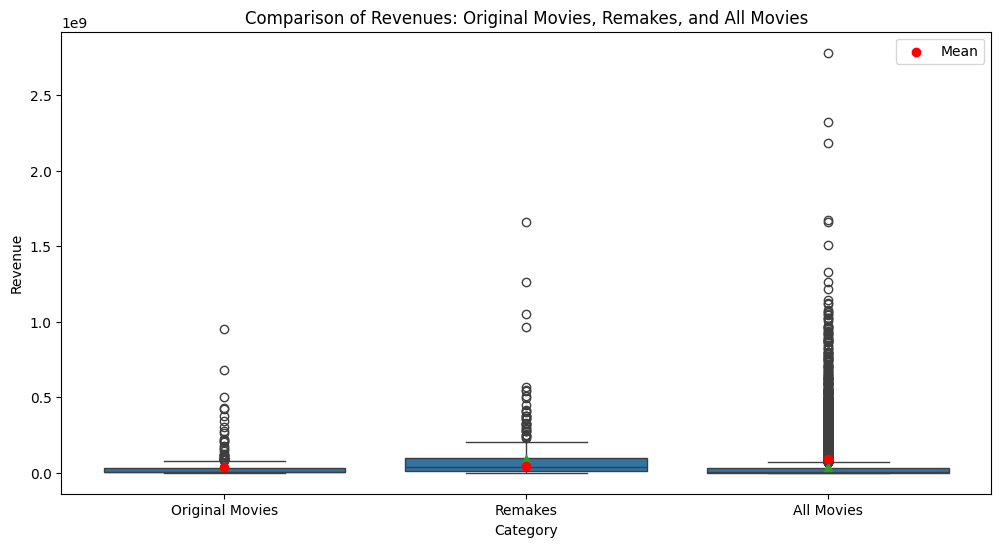

In [110]:
# Reset indices of each DataFrame to ensure unique indices
original_revenue = original_df["movie_revenue"].reset_index(drop=True)
remake_revenue = remakes_df["movie_revenue"].reset_index(drop=True)
all_revenue = df_movies["movie_revenue"].reset_index(drop=True)

# Data preparation
data = {
    "Category": (
        ["Original Movies"] * len(original_revenue) +
        ["Remakes"] * len(remake_revenue) +
        ["All Movies"] * len(all_revenue)
    ),
    "Revenue": pd.concat([original_revenue, remake_revenue, all_revenue], ignore_index=True)
}

# Create a DataFrame for plotting
boxplot_data = pd.DataFrame(data)

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_data, x="Category", y="Revenue", showmeans=True)

# Add mean points explicitly for emphasis
mean_values = boxplot_data.groupby("Category")["Revenue"].mean()
for i, mean in enumerate(mean_values):
    plt.scatter(i, mean, color="red", zorder=5, label="Mean" if i == 0 else None)

# Enhance the plot
plt.title("Comparison of Revenues: Original Movies, Remakes, and All Movies")
plt.ylabel("Revenue")
plt.xlabel("Category")
plt.legend(loc="upper right")
plt.show()


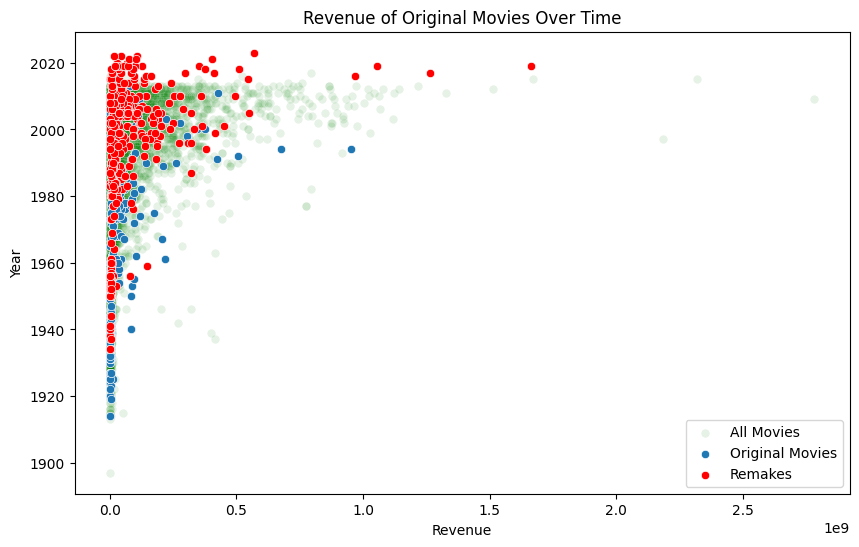

In [90]:
# scatter plot of revenues and runtimes of original movies
plt.figure(figsize=(10, 6))

sns.scatterplot(data=df_movies, x="movie_revenue", y="cmu_year", color="green", alpha=0.1, label="All Movies")

sns.scatterplot(data=original_df, x="movie_revenue", y="cmu_year", label="Original Movies")

sns.scatterplot(data=remakes_df, x="movie_revenue", y="cmu_year", color="red", label="Remakes")


plt.title("Revenue of Original Movies Over Time")
plt.xlabel("Revenue")
plt.ylabel("Year")
plt.show()

In order to investigate whether the revenue of the movies which have been remade (originals) and the whole set of movies are different we apply a **student's t** test.

In [ ]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(original_df["movie_revenue"].dropna(), df_movies["movie_revenue"].dropna())
print(f"t-statistic: {t_stat}, p-value: {p_value}")


t-statistic: 0.08469796280101127, p-value: 0.9325028916963388


We observe that the p-value is very high meaning that we cannot reject the null hypothesis that the distributions are the same.

In [ ]:
movie_remakes_df_joined = pd.merge(movie_remakes_df, df_movies, left_on="remake_wikidata_id", right_on="wikidata_id", how="inner")
movies_remakes_df_joined = pd.merge(movie_remakes_df_joined, df_movies, left_on="original_wikidata_id", right_on="wikidata_id", how="inner")

movies_remakes_df_joined.rename(columns={"movie_revenue_x": "remake_revenue", "movie_revenue_y": "original_revenue"}, inplace=True)

# keep rows with non null original and remake revenues

movies_remakes_df_joined_non_nan = movies_remakes_df_joined.dropna(subset=["remake_revenue", "original_revenue"])

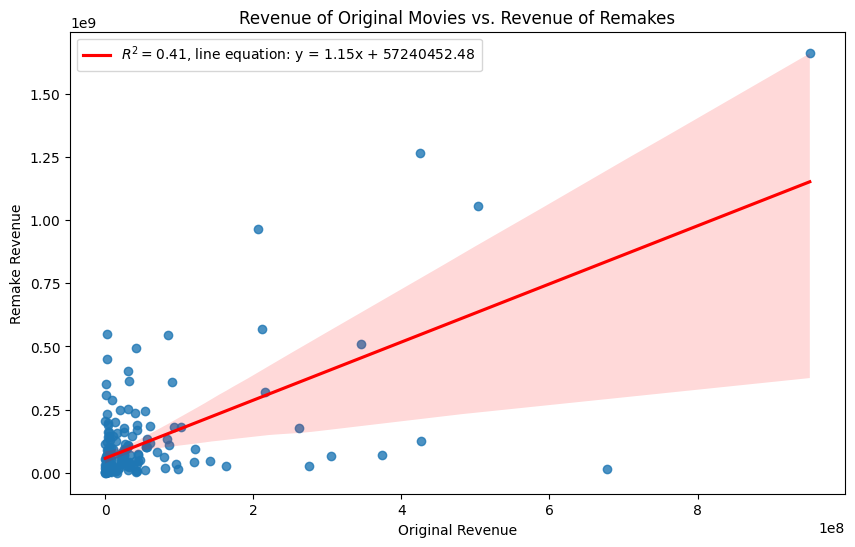

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

x = movies_remakes_df_joined_non_nan["original_revenue"]
y = movies_remakes_df_joined_non_nan["remake_revenue"]

slope, intercept, r_value, p_value, std_err = linregress(x, y)

r_squared = r_value ** 2

plt.figure(figsize=(10, 6))
sns.regplot(x=x, y=y, line_kws={"color": "red", "label": f"$R^2 = {r_squared:.2f}$, line equation: y = {slope:.2f}x + {intercept:.2f}"})

# Add plot titles and labels
plt.title("Revenue of Original Movies vs. Revenue of Remakes")
plt.xlabel("Original Revenue")
plt.ylabel("Remake Revenue")
plt.legend(loc="best")  # Show the legend with R^2 value
plt.show()


## Regression Analysis

In [140]:
df_movies["remakes_bool"] = 0
df_movies["remakes_bool"] = df_movies["remakes_bool"].astype(float)
df_movies.loc[df_movies["wikidata_id"].isin(original_movies_wikidata), "remakes_bool"] = 1

df_movies_regression = df_movies[["movie_revenue", "remakes_bool", "vote_average", "vote_count", "runtime", "budget", "popularity"]].dropna()

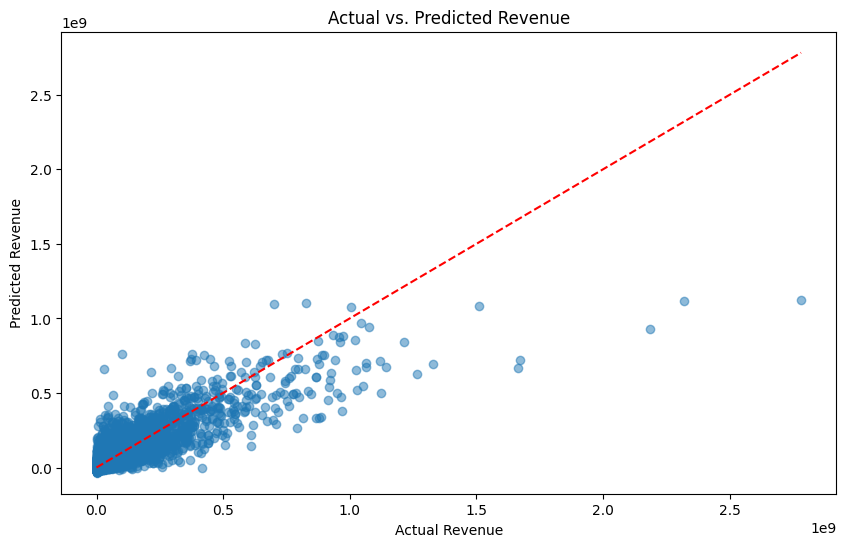

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()

X = df_movies_regression.drop(columns=["movie_revenue"])
y = df_movies_regression["movie_revenue"]

X_scaled = scaler.fit_transform(X)

regressor = LinearRegression()
regressor.fit(X_scaled, y)

y_pred = regressor.predict(X_scaled)

mse = mean_squared_error(y, y_pred)
r_squared = regressor.score(X_scaled, y)

# plot the predicted vs actual revenue

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red", linestyle="--")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs. Predicted Revenue")
plt.show()


In [142]:
# check the statistical significance of the regression coefficients

from scipy.stats import t

n = len(y)
p = X_scaled.shape[1]

dof = n - p - 1

t_values = regressor.coef_ / np.sqrt(mse / np.sum((X_scaled - X_scaled.mean(axis=0)) ** 2, axis=0))
p_values = 2 * (1 - t.cdf(np.abs(t_values), dof))

# Create a DataFrame to display the results
results = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": regressor.coef_,
    "t-value": t_values,
    "p-value": p_values
})

print(results)

        Feature   Coefficient    t-value   p-value
0  remakes_bool  7.938167e+05   0.897335  0.369571
1  vote_average -3.068303e+06  -3.468428  0.000527
2    vote_count  6.800233e+07  76.870258  0.000000
3       runtime  2.148477e+06   2.428652  0.015180
4        budget  5.800509e+07  65.569315  0.000000
5    popularity  8.030862e+06   9.078137  0.000000


## Movie stars analysis

In [ ]:
# movie stars

movie_stars = df_chars["actor_name"].value_counts().head(100).index

In [ ]:
movie_stars_df = df_chars.groupby("Wikipedia_movie_ID")["actor_name"].apply(lambda x: x.isin(movie_stars).sum()).reset_index(name="movie_stars")

In [ ]:
df_movies = pd.merge(df_movies, movie_stars_df, on="Wikipedia_movie_ID", how="left")
df_movies

,Wikipedia_movie_ID,Freebase_movie_ID,movie_name,movie_date,movie_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_year,movie_stars
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"Horror, Adventure, Supernatural, Space western...",2001.0,0.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English Language,United States of America,"Crime Drama, Biographical film, Drama, Mystery",2000.0,0.0
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Drama, Crime Fiction",1988.0,0.0
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"Psychological thriller, Erotic thriller, Thriller",1987.0,0.0
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,German Language,Germany,Drama,1983.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,English Language,United States of America,Drama,2011.0,NaN
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,English Language,"Ireland, United Kingdom","Biographical film, Documentary, Drama",2011.0,NaN
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,English Language,United States of America,"Satire, Comedy",1972.0,0.0
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,Japanese Language,Japan,"Adventure, Animation, Japanese Movies, Short F...",1992.0,0.0


In [ ]:
# movies which have co-stars

remakes1 = pd.merge(remakes1, movie_stars_df, on="Wikipedia_movie_ID", how="left")
remakes1

,Wikipedia_movie_ID,Freebase_movie_ID,movie_name,movie_date,movie_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_year,movie_stars
0,10705531,/m/02qmrx5,On the Beach,2000,NaN,195.0,English Language,"United States of America, Australia","Science Fiction, Television movie, Action/Adve...",2000.0,0.0
1,4002677,/m/0bb_jr,The 39 Steps,1959-03-13,NaN,93.0,English Language,United Kingdom,"Suspense, Mystery, Film adaptation, Remake, Sp...",1959.0,0.0
2,22358819,/m/05szq8z,Clash of the Titans,2010-03-26,493214993.0,96.0,English Language,"United States of America, United Kingdom","Adventure, Remake, Action/Adventure, Fantasy, ...",2010.0,0.0
3,5884079,/m/0fbrd7,Bangkok Dangerous,2008-08-22,82486154.0,97.0,"Thai Language, English Language",United States of America,"Crime Thriller, Crime Fiction, Action/Adventur...",2008.0,0.0
4,18579003,/m/04f_wj4,The Good Companions,1957-04-22,NaN,104.0,English Language,United Kingdom,Musical,1957.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
382,8634603,/m/027bx6_,The Plank,1979,NaN,30.0,English Language,United Kingdom,"Short Film, Comedy",1979.0,0.0
383,699336,/m/033t6r,Nine Months,1995-07-14,138510230.0,103.0,English Language,United States of America,"Romance Film, Romantic comedy, Comedy, Domesti...",1995.0,0.0
384,4057650,/m/0bfy61,To Be or Not to Be,1983-12-16,13030214.0,107.0,English Language,United States of America,"Parody, Satire, Comedy, LGBT",1983.0,0.0
385,5971762,/m/0fhdck,The Truth About Charlie,2002-10-16,7093284.0,104.0,"Arabic Language, English Language, French Lang...","United States of America, Germany","Suspense, Crime Thriller, Mystery, Comedy, Rom...",2002.0,0.0


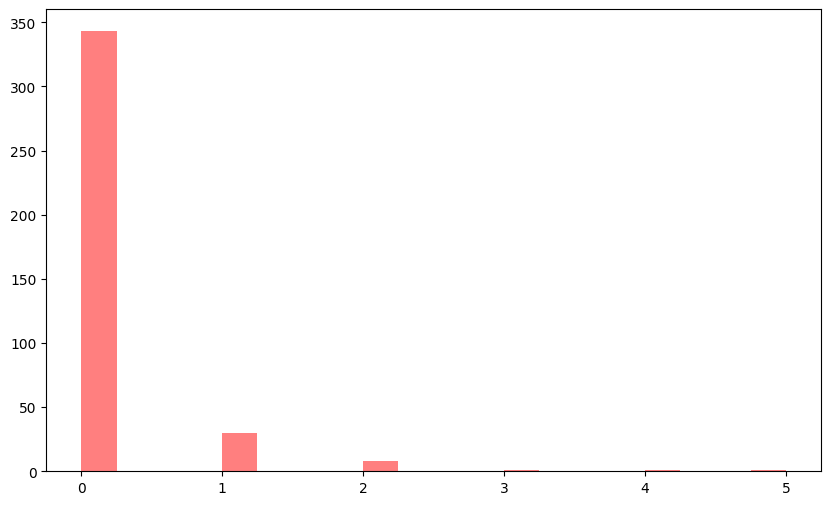

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(remakes1["movie_stars"], bins=20, color="red", alpha=0.5, label="Remakes")
plt.show()

In [ ]:
originals_df = pd.merge(originals_df, movie_stars_df, on="Wikipedia_movie_ID", how="left")
originals_df

,Wikipedia_movie_ID,Freebase_movie_ID,movie_name,movie_date,movie_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_year,movie_stars
0,196176,/m/01bwgr,Straw Dogs,1971-11-03,11148828.0,118.0,English Language,"United States of America, United Kingdom","Drama, Thriller",1971.0,0.0
1,413207,/m/025cm9,Taxi,1998-04-08,NaN,86.0,French Language,France,"Comedy, Crime Fiction, Buddy film",1998.0,0.0
2,1135297,/m/04993j,13 Ghosts,1960-07,NaN,172.0,English Language,United States of America,Horror,1960.0,0.0
3,9404578,/m/0287gvq,The Lady Vanishes,1938,NaN,97.0,English Language,United Kingdom,"Mystery, Comedy, Spy, Black-and-white, Psychol...",1938.0,0.0
4,17711304,/m/047n81_,Rendezvous,1935-10-24,NaN,94.0,English Language,United States of America,"Spy, Black-and-white",1935.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
455,5082822,/m/0d1yd3,Going in Style,1979,NaN,98.0,English Language,United States of America,"Caper story, Crime Comedy, Slapstick, Heist, C...",1979.0,0.0
456,253833,/m/01ln7k,The Mummy,1932-12-22,NaN,74.0,English Language,United States of America,"Horror, Monster movie, Archaeology, Pre-Code, ...",1932.0,1.0
457,80923,/m/0kxg6,A Letter to Three Wives,1949-01-20,NaN,103.0,English Language,United States of America,"Mystery, Film adaptation, Comedy, Drama, Roman...",1949.0,0.0
458,616805,/m/02x0cf,Kiss of Death,1947-08-27,NaN,98.0,English Language,United States of America,"Crime Thriller, Crime Fiction, Film noir, Blac...",1947.0,0.0


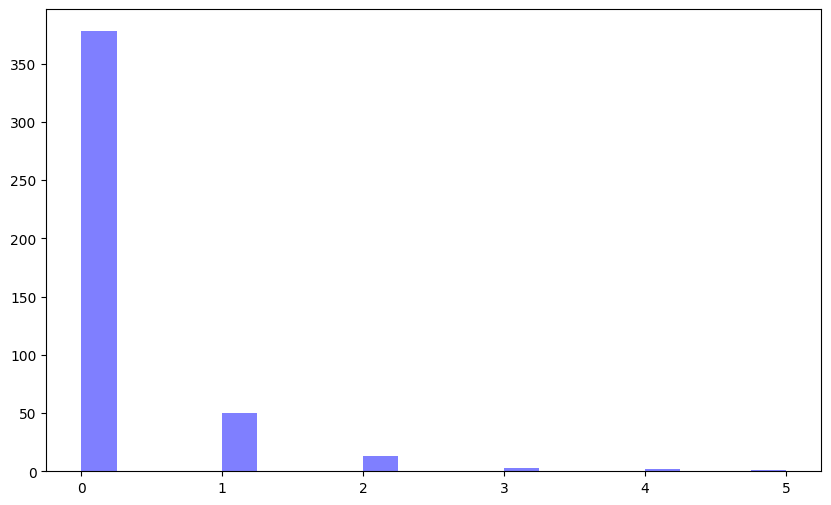

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(originals_df["movie_stars"], bins=20, color="blue", alpha=0.5, label="Originals")
plt.show()
